## 投票机制

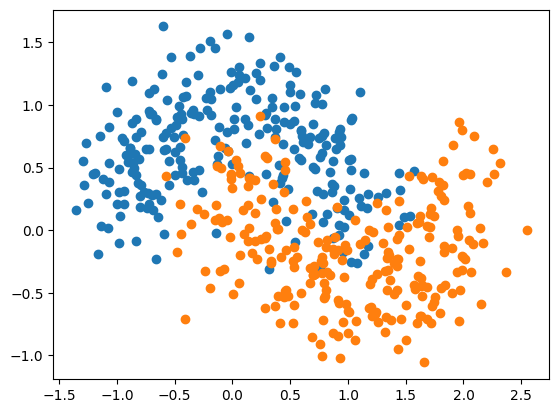

In [3]:
from sklearn.datasets import make_moons as MM
import matplotlib.pyplot as plt

X, Y = MM(n_samples=500, noise=0.3, random_state=2024)

plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=2024)

## 测试LR，SVM和DTC的分类结果，并使用投票器对结果进行综合处理
from sklearn.linear_model import LogisticRegression as LR

lr_clf = LR()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test) # LR在测试集上的准确率为82.4%

0.824

In [5]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test) # SVM在测试集上的准确率为85.6%

0.856

In [6]:
from sklearn.tree import DecisionTreeClassifier as DTC

dt_clf = DTC()
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test) # 决策树在测试集上的准确率为84%

0.84

In [7]:
import numpy as np
# 设计投票机制，对于一个未知样本，如果三个算法中有不少于2个认为它是正例
# 就判定为正例
y_pred1 = lr_clf.predict(X_test)
y_pred2 = lr_clf.predict(X_test)
y_pred3 = lr_clf.predict(X_test)

y_pred = np.array((y_pred1+y_pred2+y_pred3) >= 2, dtype=np.int32)

In [8]:
# 计算投票器的准确率
from sklearn.metrics import accuracy_score as ACC
ACC(y_test, y_pred) # 投票器准确率为82.4%

0.824

In [9]:
# 调用sklearn中的接口: Hard Voting
from sklearn.ensemble import VotingClassifier as VC

voting_clf = VC(estimators=[
    ('lr_clf', LR()),
    ('svm_clf', SVC()),
    ('dt_clf', DTC())
], voting='hard') #准确率84%

voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.84

In [11]:
# 调用sklearn中的接口: Soft Voting
voting_clf2 = VC(estimators=[
    ('lr_clf', LR()),
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DTC())
], voting='soft') #准确率85.6%

voting_clf2.fit(X_train, y_train)
voting_clf2.score(X_test, y_test)

0.856

## Bagging集成算法

In [13]:
from sklearn.ensemble import BaggingClassifier as BC

bagging_clf = BC(
    DTC(), # 被集成的算法为决策树
    n_estimators= 500, # 集成500个决策树
    max_samples= 100, # 每个子模型最多观测数据集中100个样本
    bootstrap= True # 进行可放回抽样
)

bagging_clf.fit(X_train, y_train)
bagging_clf.score(X_test, y_test) # 准确率85.6%

0.856

In [14]:
# 提高参数

bagging_clf2 = BC(
    DTC(), # 被集成的算法为决策树
    n_estimators= 5000, # 集成5000个决策树
    max_samples= 200, # 每个子模型最多观测数据集中200个样本
    bootstrap= True # 进行可放回抽样
)

bagging_clf2.fit(X_train, y_train)
bagging_clf2.score(X_test, y_test) # 准确率84%

0.84

In [15]:
# OOB (Out-of-Bag)
# 数据集划分为N份，某数据集一直不被bootstrap抽中的概率为(1-1/N)^N = 1/e = 37%
# 这部分数据集可以作为测试集

bagging_clf_oob = BC(
    DTC(), # 被集成的算法为决策树
    n_estimators= 500, # 集成500个决策树
    max_samples= 100, # 每个子模型最多观测数据集中100个样本
    bootstrap= True, # 进行可放回抽样
    oob_score= True
)

bagging_clf_oob.fit(X, Y) # OOB策略下直接拟合全样本即可
bagging_clf_oob.oob_score_ # 准确率90.8%

0.908

In [16]:
# Random Subspace
# 特征空间随机采样

bagging_clf_oob_rf = BC(
    DTC(), # 被集成的算法为决策树
    n_estimators= 500, # 集成500个决策树
    max_samples= 100, # 每个子模型最多观测数据集中100个样本
    bootstrap= True, # 进行可放回抽样
    oob_score= True,
    n_jobs=-1,
    max_features=1, # 特征随机采样
    bootstrap_features= True # 特征采样使用bootstrap
)

bagging_clf_oob_rf.fit(X, Y) # OOB策略下直接拟合全样本即可
bagging_clf_oob_rf.oob_score_ # 准确率86%

0.86

## 随机森林

In [17]:
from sklearn.ensemble import RandomForestClassifier as RFC

rf_clf = RFC(
    n_estimators= 500,
    random_state= 2024,
    oob_score= True,
    n_jobs=-1
)

rf_clf.fit(X, Y)
rf_clf.oob_score_ # 准确率89.4%

0.894

In [18]:
# 使用随机特征和随机阈值 ：Extra-Tree
from sklearn.ensemble import ExtraTreesClassifier as ETC

et_clf = ETC(
    n_estimators= 500,
    bootstrap= True,
    oob_score= True,
    random_state= 2024
)

et_clf.fit(X, Y)
et_clf.oob_score_ # 准确率90%

0.9

In [19]:
# AdaBoost, 在上一轮拟合结果的基础上，增加对未拟合到的样本点的权重
from sklearn.ensemble import AdaBoostClassifier as ABC

ada_clf = ABC(
    DTC(max_depth= 2),
    n_estimators= 500
)

ada_clf.fit(X_train, y_train)
ada_clf.score(X_test, y_test) # 准确率81.6%

0.816

In [20]:
# GradientBoost, 针对上一轮的错误分类进行训练
from sklearn.ensemble import GradientBoostingClassifier as GBC

gbc_clf = GBC(
    n_estimators=30,
    max_depth=2
)

gbc_clf.fit(X_train, y_train)
gbc_clf.score(X_test, y_test) # 准确率84.8%

0.848